In [1]:
#pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score

# 1. Load Data prepared for Tree-based models
X_train = pd.read_parquet('X_train_tree_ready.parquet', engine='fastparquet')
X_test = pd.read_parquet('X_test_tree_ready.parquet', engine='fastparquet')

y_train = pd.read_csv('y_train_tree_ready.csv').values.ravel()
y_test = pd.read_csv('y_test_tree_ready.csv').values.ravel()

print(f"Data Loaded.")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape : {X_test.shape}")

Data Loaded.
   Train shape: (1258858, 105)
   Test shape : (261278, 105)


In [3]:
# 2. Define Models dictionary
# We use reasonable default hyperparameters for a fair first comparison.
# n_jobs=-1 ensures we use all CPU cores for faster training.

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        max_depth=12,      
        random_state=42, 
        n_jobs=-1
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=8,        
        eval_metric='logloss', 
        random_state=42,
        n_jobs=-1
    ),
    
    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,     
        random_state=42,
        n_jobs=-1,
        verbose=-1          
    )
}

print(f"Models initialized: {list(models.keys())}")

Models initialized: ['Random Forest', 'XGBoost', 'LightGBM']


Starting model comparison

Training Random Forest...
Done in 440.8s | AUC: 0.6874
Training XGBoost...

Top 10 features for XGBoost (importance type = 'gain') :
                Feature   Importance
0                  term  2015.849243
1   verification_status   961.161377
2        inq_last_6mths   705.424805
3        home_ownership   648.642456
4    num_tl_op_past_12m   563.429138
5              int_rate   502.993530
6  acc_open_past_24mths   393.700745
7              mort_acc   355.754303
8               purpose   286.466675
9  composite_risk_score   261.889343 

Done in 67.1s | AUC: 0.7031
Training LightGBM...
Done in 54.9s | AUC: 0.7055


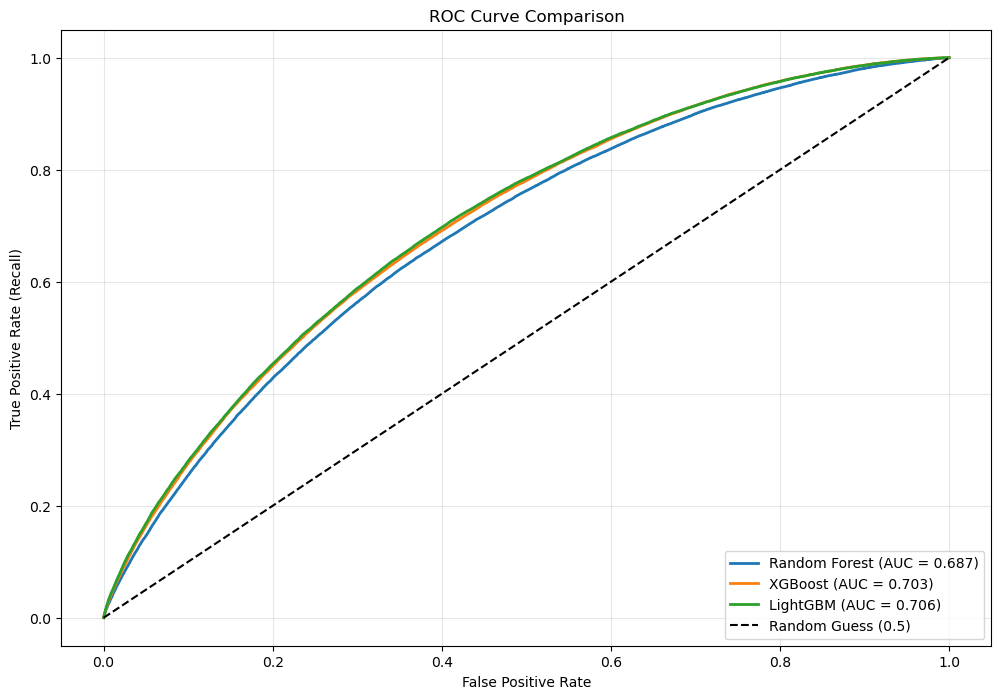

In [4]:
# 3. Training and Evaluation Loop
results = []

# Initialize plot for ROC Curves
plt.figure(figsize=(12, 8))

print("Starting model comparison\n")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on Test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability of Default 
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Calculate Metrics
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)      
    prec = precision_score(y_test, y_pred)  
    
    # Store results
    results.append({
        "Model": name,
        "ROC-AUC": auc,
        "Accuracy": acc,
        "Recall (Default)": rec,
        "Precision": prec,
        "Time (s)": round(elapsed_time, 2)
    })

    if name.lower() in ["xgboost", "xgb", "xgbclassifier"]:
        booster = model.get_booster()
        score = booster.get_score(importance_type='gain')  
        
        mapping = {f"f{i}": col for i, col in enumerate(X_train.columns)}
        
        # 3) Creation of sorted Dataframe
        xgb_feature_importances = (
            pd.DataFrame(
                [(mapping.get(f, f), imp) for f, imp in score.items()],
                columns=["Feature", "Importance"]
            )
            .sort_values("Importance", ascending=False)
            .reset_index(drop=True)
        )
        
        print("\nTop 10 features for XGBoost (importance type = 'gain') :")
        print(xgb_feature_importances.head(10), "\n")
    
    # Add ROC Curve to plot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)
    
    print(f"Done in {elapsed_time:.1f}s | AUC: {auc:.4f}")

# Finalize ROC Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [5]:
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    log_loss, 
    average_precision_score, 
    confusion_matrix, 
    precision_recall_curve,
    balanced_accuracy_score
)

Starting comprehensive model comparison

Training Random Forest...
   Done in 313.2s | ROC-AUC: 0.6874 | F1: 0.3859
Training XGBoost...
   Done in 45.2s | ROC-AUC: 0.7031 | F1: 0.3398
Training LightGBM...
   Done in 36.6s | ROC-AUC: 0.7055 | F1: 0.4174


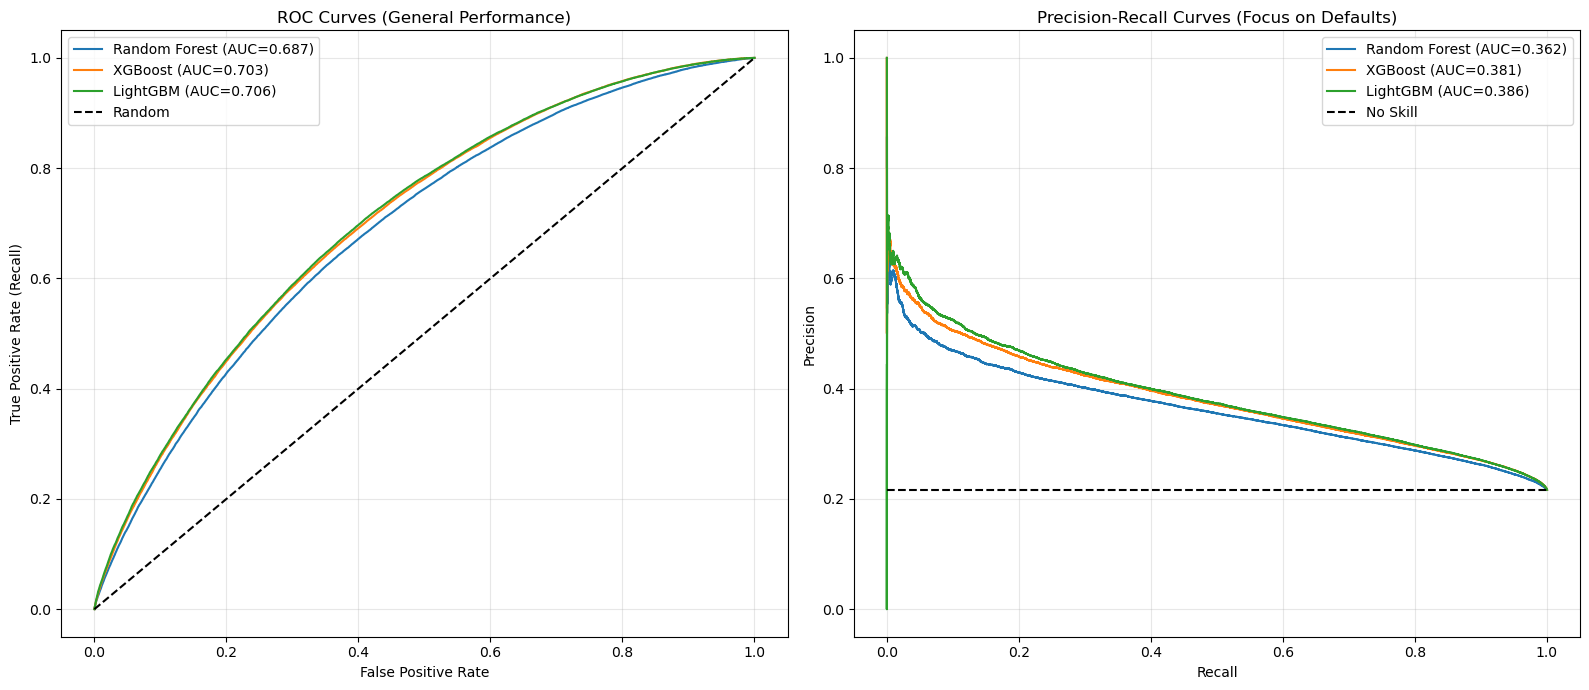

In [6]:
# 3. Comprehensive Training and Evaluation Loop
results = []

# Setup plot area (2 subplots: ROC and PR Curve)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

print("Starting comprehensive model comparison\n")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    elapsed_time = time.time() - start_time
    
    # --- Calculate all metrics ---
    
    # Basic Classification Metrics
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    
    # Advanced Probabilistic Metrics
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob) 
    ll = log_loss(y_test, y_prob)
    
    # Specificity (True Negative Rate) via Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Store in dictionary
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,      
        "F1-Score": f1,         
        "Accuracy": acc,
        "Balanced Acc": bal_acc,
        "Recall": rec,
        "Precision": prec,
        "Specificity": specificity,
        "Log Loss": ll,
        "Time (s)": round(elapsed_time, 2)
    })
    
    # Plotting 
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax1.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    
    # 2. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    ax2.plot(recall_curve, precision_curve, label=f"{name} (AUC={pr_auc:.3f})")
    
    print(f"   Done in {elapsed_time:.1f}s | ROC-AUC: {roc_auc:.4f} | F1: {f1:.4f}")

# Finalize Plots
# ROC
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curves (General Performance)')
ax1.legend()
ax1.grid(alpha=0.3)

# Precision
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves (Focus on Defaults)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

,ROC-AUC,PR-AUC,F1-Score,Accuracy,Balanced Acc,Recall,Precision,Specificity,Log Loss,Time (s)
Model,,,,,,,,,,
LightGBM,0.7055,0.3861,0.4174,0.7236,0.6272,0.4572,0.3840,0.7973,0.5381,36.5900
XGBoost,0.7031,0.3810,0.3398,0.7639,0.5890,0.2807,0.4306,0.8974,0.5018,45.2400
Random Forest,0.6874,0.3623,0.3859,0.7294,0.6076,0.3926,0.3794,0.8225,0.5716,313.1900


C:\Users\sagro\AppData\Local\Temp\ipykernel_119996\1555201143.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PR-AUC", y=results_df.index, data=results_df, palette="viridis")


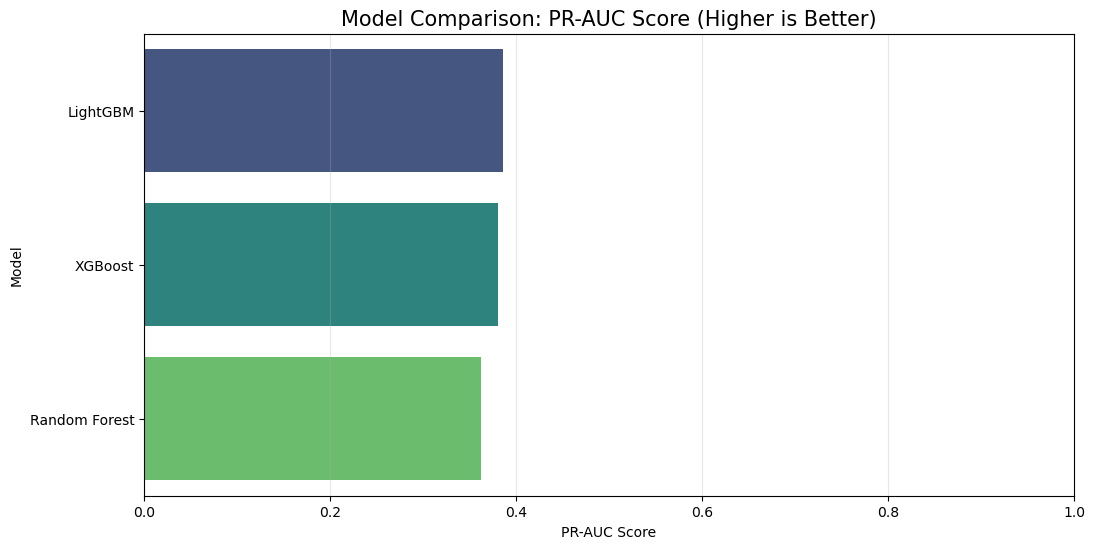

C:\Users\sagro\AppData\Local\Temp\ipykernel_119996\1555201143.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Time (s)", y=results_df.index, data=results_df, palette="Reds")


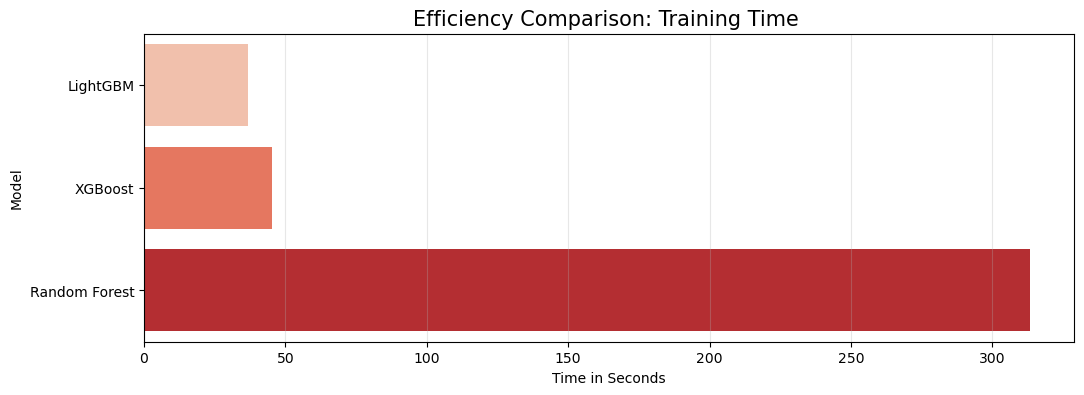

In [7]:
# 4. Final Leaderboard & Visualization

# Create DataFrame from the results list
results_df = pd.DataFrame(results).set_index("Model")

# Sort models by PR-AUC 
# This is generally the best metric for Imbalanced Classification
results_df = results_df.sort_values(by="PR-AUC", ascending=False)



# Display the table with a color gradient
# We highlight the key performance metrics
display(results_df.style.background_gradient(
    cmap='Greens', 
    subset=['ROC-AUC', 'PR-AUC', 'F1-Score', 'Balanced Acc', 'Recall', 'Specificity']
).format("{:.4f}")) 

# Visualization 
plt.figure(figsize=(12, 6))

# Bar plot of PR-AUC scores
sns.barplot(x="PR-AUC", y=results_df.index, data=results_df, palette="viridis")

plt.title("Model Comparison: PR-AUC Score (Higher is Better)", fontsize=15)
plt.xlabel("PR-AUC Score")
plt.ylabel("Model")
plt.xlim(0, 1.0) 
plt.grid(axis='x', alpha=0.3)
plt.show()

#  Training Time Comparison 
plt.figure(figsize=(12, 4))
sns.barplot(x="Time (s)", y=results_df.index, data=results_df, palette="Reds")
plt.title("Efficiency Comparison: Training Time ", fontsize=15)
plt.xlabel("Time in Seconds")
plt.grid(axis='x', alpha=0.3)
plt.show()